# 성심당 방문객 찾기 & 유동인구 시각화 

## 1. 라이브러리 & 데이터

In [3]:
# 데이터 처리 및 분석 관련 라이브러리
import pandas as pd
import numpy as np
import zipfile

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
import geopandas as gpd

# 한글 폰트 및 기타 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우의 경우
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 지리 정보 및 매핑 툴
from pyproj import Proj, Transformer
from geopy.distance import geodesic
from folium.plugins import HeatMap

# 유틸리티 및 보조 도구
import warnings
import holidays
from tqdm import tqdm
import json
import os
import imageio
from selenium import webdriver
from PIL import Image, ImageDraw, ImageFont
import time

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',300)

### 데이터셋 불러오기

In [4]:
유동인구정의서 = pd.read_excel("../data/유동인구정의서.xlsx", header=2)
국토조사 = pd.read_csv("../data/국토지리정보원_국토조사_(격자)500M.csv")
업종 = pd.read_csv("../data/업종코드.csv")
hdong = pd.read_csv("../data/행정동코드.csv")
관광지 = pd.read_csv("../data/대전_관광지.csv")
card1 = pd.read_csv("../data/card1.csv") # 202307-202406 기간 모두 합친 데이터
card2 = pd.read_csv("../data/card2.csv") # 202307-202406 기간 모두 합친 데이터
pop_may = pd.read_csv("../data/50CELL_DJJUNGGU_202405.csv") # 5월 유동인구 데이터

### 행정동코드 데이터 전처리

In [5]:
hdong['행정동코드'] = hdong['행정동코드'].astype(str).str[:-2].astype(int)
hdong['시군구코드'] = hdong['행정동코드'].astype(str).str[:-3].astype(int)
hdong['시도코드'] = hdong['시군구코드'].astype(str).str[:-3].astype(int)
# 앞자리가 51인 경우에만 42로 변경하는 함수 정의
def replace_prefix_51_with_42(column):
    return column.apply(lambda x: int('42' + str(x)[2:]) if str(x).startswith('51') else x)

# 행정동코드, 시도코드, 시군구코드 열의 앞자리가 51인 경우만 변경
hdong['행정동코드'] = replace_prefix_51_with_42(hdong['행정동코드'])
hdong['시도코드'] = replace_prefix_51_with_42(hdong['시도코드'])
hdong['시군구코드'] = replace_prefix_51_with_42(hdong['시군구코드'])

## 2. 전처리

### 2.1 card1 데이터에서 성심당 결제가 가장 많은 “달“ 구하기

In [6]:
# card1에 격자 합치기
card1 = pd.merge(card1, 국토조사, how = 'left', left_on = 'cell_id', right_on = '격자ID')
card1 = card1.drop('격자ID', axis=1)

In [7]:
# cell_id가 성심당이 맞는지 지도로 확인

# Shapefile 파일 위치
os.chdir("../data")

# Shapefile 읽기 및 인코딩 수정
gdf = gpd.read_file('빈격자(500m).shp', encoding="utf-8") 

# 대전 중구에 해당하는 격자만 필터링
gdf = gdf[gdf['SECT_CD'] == '30140']

# 좌표계 확인 및 변환 (EPSG:4326)
if gdf.crs != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)

# 대전 중구 중심 좌표 설정
map_center = [36.321655, 127.419525]

# folium 지도 생성 (대전 중구를 중심으로)
m = folium.Map(location=map_center, zoom_start=13)

# 대전 중구의 격자 데이터를 지도에 폴리곤으로 추가
for idx, row in gdf.iterrows():
    style = {'fillColor': 'black', 'color': 'black', 'weight': 1, 'fillOpacity': 0.2}
    if row['SPO_NO_CD'] == '다바93a14a':  # '다바93a14a'는 빨간색으로 표시
        style = {'fillColor': 'red', 'color': 'red', 'weight': 2, 'fillOpacity': 0.4}
    
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x, style=style: style 
    ).add_to(m)

# 지도 출력
m

In [8]:
# 성심당 추정 데이터만 불러오기
sungsim = card1.loc[
    (card1['cell_id'] == '다바93a14a') &
    (card1['x좌표'] == 993000) &
    (card1['y좌표'] == 1814000) &
    (card1['업종소분류'] == 'I56191')
]

# 결과 출력
sungsim

,기준일자,cell_id,업종대분류,업종중분류,업종소분류,이용건수,이용건수_지역화폐,이용건수_재난지원금,이용건수_기타,이용금액,이용금액_지역화폐,이용금액_재난지원금,이용금액_기타,x좌표,y좌표
1234,20230701,다바93a14a,I,56.0,I56191,1185,81,0,1104,23338695,1264270,0,22074425,993000,1814000
2449,20230702,다바93a14a,I,56.0,I56191,1102,69,0,1033,21009061,964721,0,20044340,993000,1814000
4012,20230703,다바93a14a,I,56.0,I56191,743,44,0,699,13602795,671700,0,12931095,993000,1814000
5648,20230704,다바93a14a,I,56.0,I56191,604,26,0,578,11689320,386800,0,11302520,993000,1814000
7314,20230705,다바93a14a,I,56.0,I56191,818,48,0,770,15850685,662000,0,15188685,993000,1814000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561099,20240626,다바93a14a,I,56.0,I56191,1162,15,0,1147,30175120,250600,0,29924520,993000,1814000
562799,20240627,다바93a14a,I,56.0,I56191,1231,19,0,1212,28430625,253800,0,28176825,993000,1814000
564498,20240628,다바93a14a,I,56.0,I56191,1508,14,0,1494,39869820,241840,0,39627980,993000,1814000
566042,20240629,다바93a14a,I,56.0,I56191,1337,18,0,1319,36176615,602650,0,35573965,993000,1814000


In [9]:
# 날짜 변수(기준일자)를 datetime 타입으로 변환
sungsim['기준일자'] = pd.to_datetime(sungsim['기준일자'], format='%Y%m%d')

In [10]:
# '월' 열 추가 (날짜에서 월만 추출)
sungsim['월'] = sungsim['기준일자'].dt.month

In [11]:
sungsim.groupby('월')['이용건수'].sum().reset_index().sort_values('이용건수',ascending=False)

,월,이용건수
4,5,40000
5,6,38762
11,12,37955
2,3,36938
3,4,35832
1,2,34630
7,8,33073
0,1,33028
8,9,32260
10,11,30051


In [12]:
sungsim.groupby('월')['이용금액'].sum().reset_index().sort_values('이용금액',ascending=False)

,월,이용금액
4,5,1081229123
11,12,1044235910
5,6,1017948143
1,2,911806385
2,3,905970004
3,4,872996841
0,1,806727840
8,9,730316164
10,11,712505075
7,8,673504224


### 2.2 card2 데이터에서 성심당 가장 제일 많이 이용하는(횟수합) “성별_나이” 순위 매기기

card2에서 5월만 추출하기

In [13]:
card2_merge = pd.merge(card2, 업종[['항목명','업종소분류']], how = 'left', left_on = '업종소분류', right_on = '업종소분류')

# 항목명 컬럼명을 소분류 업종명으로 바꾸기
card2_merge = card2_merge.rename(columns={"항목명": "소분류 업종명"})

In [14]:
# 5월의 데이터만 추출
card2_may = card2_merge[card2_merge['기준년월'] == 202405]

In [15]:
# 성심당 이용 고객 추출
sungsim_card = card2_may[(card2_may['업종소분류'] == 'I56191') & (card2_may['행정동_상권'] == 30140535) & (card2_may['업력'] == '10년초과') & (card2_may['광역시_유입'] != 30) & (card2_may['구분_시간대'] != 5) & (card2_may['구분_개인법인'] == 1) ]

In [16]:
# 광역시_유입, 업종소분류, 연령, 성별, 행정동_상권 NaN 값 제거
sungsim_card = sungsim_card.dropna(subset=['광역시_유입', '업종소분류', '연령', '성별', '행정동_상권'])

In [17]:
# sungsim_card 데이터프레임을 csv파일로 저장 
#sungsim_card.to_csv('sungsim_card.csv', index=False, encoding='utf-8-sig')

In [18]:
# 이용건수 합산
usage_sum = sungsim_card.groupby(['성별', '연령'])['이용건수'].sum().reset_index()

# 이용건수에 따른 순위 매기기
usage_sum['순위'] = usage_sum['이용건수'].rank(method='max', ascending=False)

# 순위에 따라 데이터 정렬
usage_sum_sorted = usage_sum.sort_values(by='순위')

# 결과 출력
usage_sum_sorted

,성별,연령,이용건수,순위
1,F,2.0,4510,1.0
2,F,3.0,2122,2.0
8,M,3.0,2079,3.0
9,M,4.0,1843,4.0
7,M,2.0,1830,5.0
10,M,5.0,1690,6.0
3,F,4.0,1409,7.0
4,F,5.0,1304,8.0
11,M,6.0,411,9.0
5,F,6.0,390,10.0


In [19]:
# 이용금액 합산
usage_sum = sungsim_card.groupby(['성별', '연령'])['이용금액'].sum().reset_index()

# 이용금액에 따른 순위 매기기
usage_sum['순위'] = usage_sum['이용금액'].rank(method='max', ascending=False)

# 순위에 따라 데이터 정렬
usage_sum_sorted = usage_sum.sort_values(by='순위')

# 결과 출력
usage_sum_sorted

,성별,연령,이용금액,순위
1,F,2.0,111495165,1.0
8,M,3.0,60075133,2.0
2,F,3.0,58719680,3.0
9,M,4.0,56420190,4.0
10,M,5.0,51385860,5.0
7,M,2.0,46424425,6.0
3,F,4.0,40896250,7.0
4,F,5.0,36143700,8.0
11,M,6.0,11716200,9.0
5,F,6.0,10288400,10.0


### 2.3 5월 유동인구 데이터 분석 

### 유동인구 범주 줄이기 

In [20]:
# 유동인구정의서에서 '항목 설명' 열을 가져오기
new_columns = 유동인구정의서['항목 설명'].values

# pop_may 안의 모든 데이터프레임의 컬럼 이름을 변경
pop_may.columns = new_columns

In [21]:
# 남성 연령대 그룹
pop_may['남성_10대'] = pop_may[['남성10~14', '남성15~19']].sum(axis=1)
pop_may['남성_20대'] = pop_may[['남성20~24', '남성25~29']].sum(axis=1)
pop_may['남성_30대'] = pop_may[['남성30~34', '남성35~39']].sum(axis=1)
pop_may['남성_40대'] = pop_may[['남성40~44', '남성45~49']].sum(axis=1)
pop_may['남성_50대'] = pop_may[['남성50~54', '남성55~59']].sum(axis=1)
pop_may['남성_60대'] = pop_may[['남성60~64', '남성65~69']].sum(axis=1)
pop_may['남성_70대이상'] = pop_may[['남성70세 이상']].sum(axis=1)

# 여성 연령대 그룹
pop_may['여성_10대'] = pop_may[['여성10~14', '여성15~19']].sum(axis=1)
pop_may['여성_20대'] = pop_may[['여성20~24', '여성25~29']].sum(axis=1)
pop_may['여성_30대'] = pop_may[['여성30~34', '여성35~39']].sum(axis=1)
pop_may['여성_40대'] = pop_may[['여성40~44', '여성45~49']].sum(axis=1)
pop_may['여성_50대'] = pop_may[['여성50~54', '여성55~59']].sum(axis=1)
pop_may['여성_60대'] = pop_may[['여성60~64', '여성65~69']].sum(axis=1)
pop_may['여성_70대이상'] = pop_may[['여성70세 이상']].sum(axis=1)

# 필요 없는 기존 남성, 여성 연령대 컬럼 삭제 
columns_to_drop = [
    '남성10세미만', '남성10~14', '남성15~19', '남성20~24', '남성25~29', '남성30~34', '남성35~39', 
    '남성40~44', '남성45~49', '남성50~54', '남성55~59', '남성60~64', '남성65~69', '남성70세 이상', 
    '여성10세미만', '여성10~14', '여성15~19', '여성20~24', '여성25~29', '여성30~34', '여성35~39', 
    '여성40~44', '여성45~49', '여성50~54', '여성55~59', '여성60~64', '여성65~69', '여성70세 이상'
]

pop_may.drop(columns=columns_to_drop, inplace=True)

# 결과 확인
pop_may.head()

,셀번호,x좌표,y좌표,시간대,소계(남녀합계),행정동코드,일자,남성_10대,남성_20대,남성_30대,남성_40대,남성_50대,남성_60대,남성_70대이상,여성_10대,여성_20대,여성_30대,여성_40대,여성_50대,여성_60대,여성_70대이상
0,58904249,343802,408793,7,1.19,30140740,20240519,0.01,0.06,0.15,0.10,0.22,0.22,0.15,0.01,0.01,0.03,0.06,0.08,0.06,0.02
1,58904249,343802,408793,8,2.20,30140740,20240527,0.34,0.12,0.13,0.18,0.29,0.16,0.07,0.38,0.03,0.03,0.06,0.24,0.10,0.07
2,58904249,343802,408793,8,2.29,30140740,20240510,0.40,0.11,0.14,0.21,0.20,0.23,0.11,0.38,0.02,0.06,0.08,0.26,0.05,0.04
3,58904249,343802,408793,8,2.31,30140740,20240507,0.41,0.10,0.13,0.18,0.17,0.21,0.08,0.43,0.06,0.04,0.06,0.25,0.12,0.07
4,58904249,343802,408793,8,1.04,30140740,20240505,0.04,0.13,0.06,0.07,0.12,0.25,0.08,0.00,0.02,0.03,0.04,0.10,0.06,0.02


평일 / 휴일(토,일,빨간날) 변수 생성

In [22]:
# '일자' 열이 YYYYMMDD 형식이라 가정하고 변환
pop_may['일자'] = pd.to_datetime(pop_may['일자'], format='%Y%m%d', errors='coerce')

# 한국 공휴일 객체 생성
kr_holidays = holidays.KR()

# '휴일' 변수 생성: 토, 일요일 또는 공휴일이면 '휴일', 그렇지 않으면 '평일'
pop_may['holiday'] = pop_may['일자'].apply(lambda x: '휴일' if x.weekday() >= 5 or x in kr_holidays else '평일')


KATEC -> WGS84 변환된 df 만들기: unique_cells

In [23]:
# '셀번호'를 기준으로 그룹화하고 각 그룹의 첫 번째 'x좌표'와 'y좌표'를 선택
unique_cells = pop_may.groupby('셀번호').first().reset_index()
unique_cells = unique_cells[['셀번호', 'x좌표', 'y좌표', '행정동코드']]

# 결과 출력
unique_cells

,셀번호,x좌표,y좌표,행정동코드
0,58892059,343752,408743,30140740
1,58904248,343802,408743,30140740
2,58904249,343802,408793,30140740
3,58904250,343802,408843,30140740
4,58916437,343852,408743,30140740
...,...,...,...,...
9620,60757016,351402,410743,30140620
9621,60757017,351402,410793,30140620
9622,60757018,351402,410843,30140620
9623,60757019,351402,410893,30140620


In [24]:
tqdm.pandas()  # pandas의 tqdm 확장 활성화

# KATEC 좌표계와 WGS84 좌표계 정의
WGS84 = {'proj': 'latlong', 'datum': 'WGS84', 'ellps': 'WGS84'}
KATEC = {'proj': 'tmerc', 'lat_0': '38N', 'lon_0': '128E', 
         'ellps': 'bessel', 'x_0': 400000, 'y_0': 600000,
         'k': 0.9999, 'units': 'm',
         'towgs84': '-115.80,474.99,674.11,1.16,-2.31,-1.63,6.43'}

# KATEC -> WGS84 변환 함수
def KATEC_to_wgs84(x, y):
    transformer = Transformer.from_proj(Proj(**KATEC), Proj(**WGS84), always_xy=True)
    lon, lat = transformer.transform(x, y)
    return lat, lon

# 좌표 변환 적용 
unique_cells[['latitude', 'longitude']] = unique_cells.progress_apply(lambda row: KATEC_to_wgs84(row['x좌표'], row['y좌표']), axis=1, result_type='expand')

100%|██████████| 9625/9625 [00:29<00:00, 327.75it/s]


pop_may에서 '셀번호', 'x좌표', 'y좌표', '시간대', '행정동코드', '일자', 'holiday', '여성_20대' 변수만 사용  : pop_may_20

In [25]:
selected_columns = ['셀번호', 'x좌표', 'y좌표', '시간대', '행정동코드', '일자', 'holiday', '여성_20대']
pop_may_20 = pop_may[selected_columns]

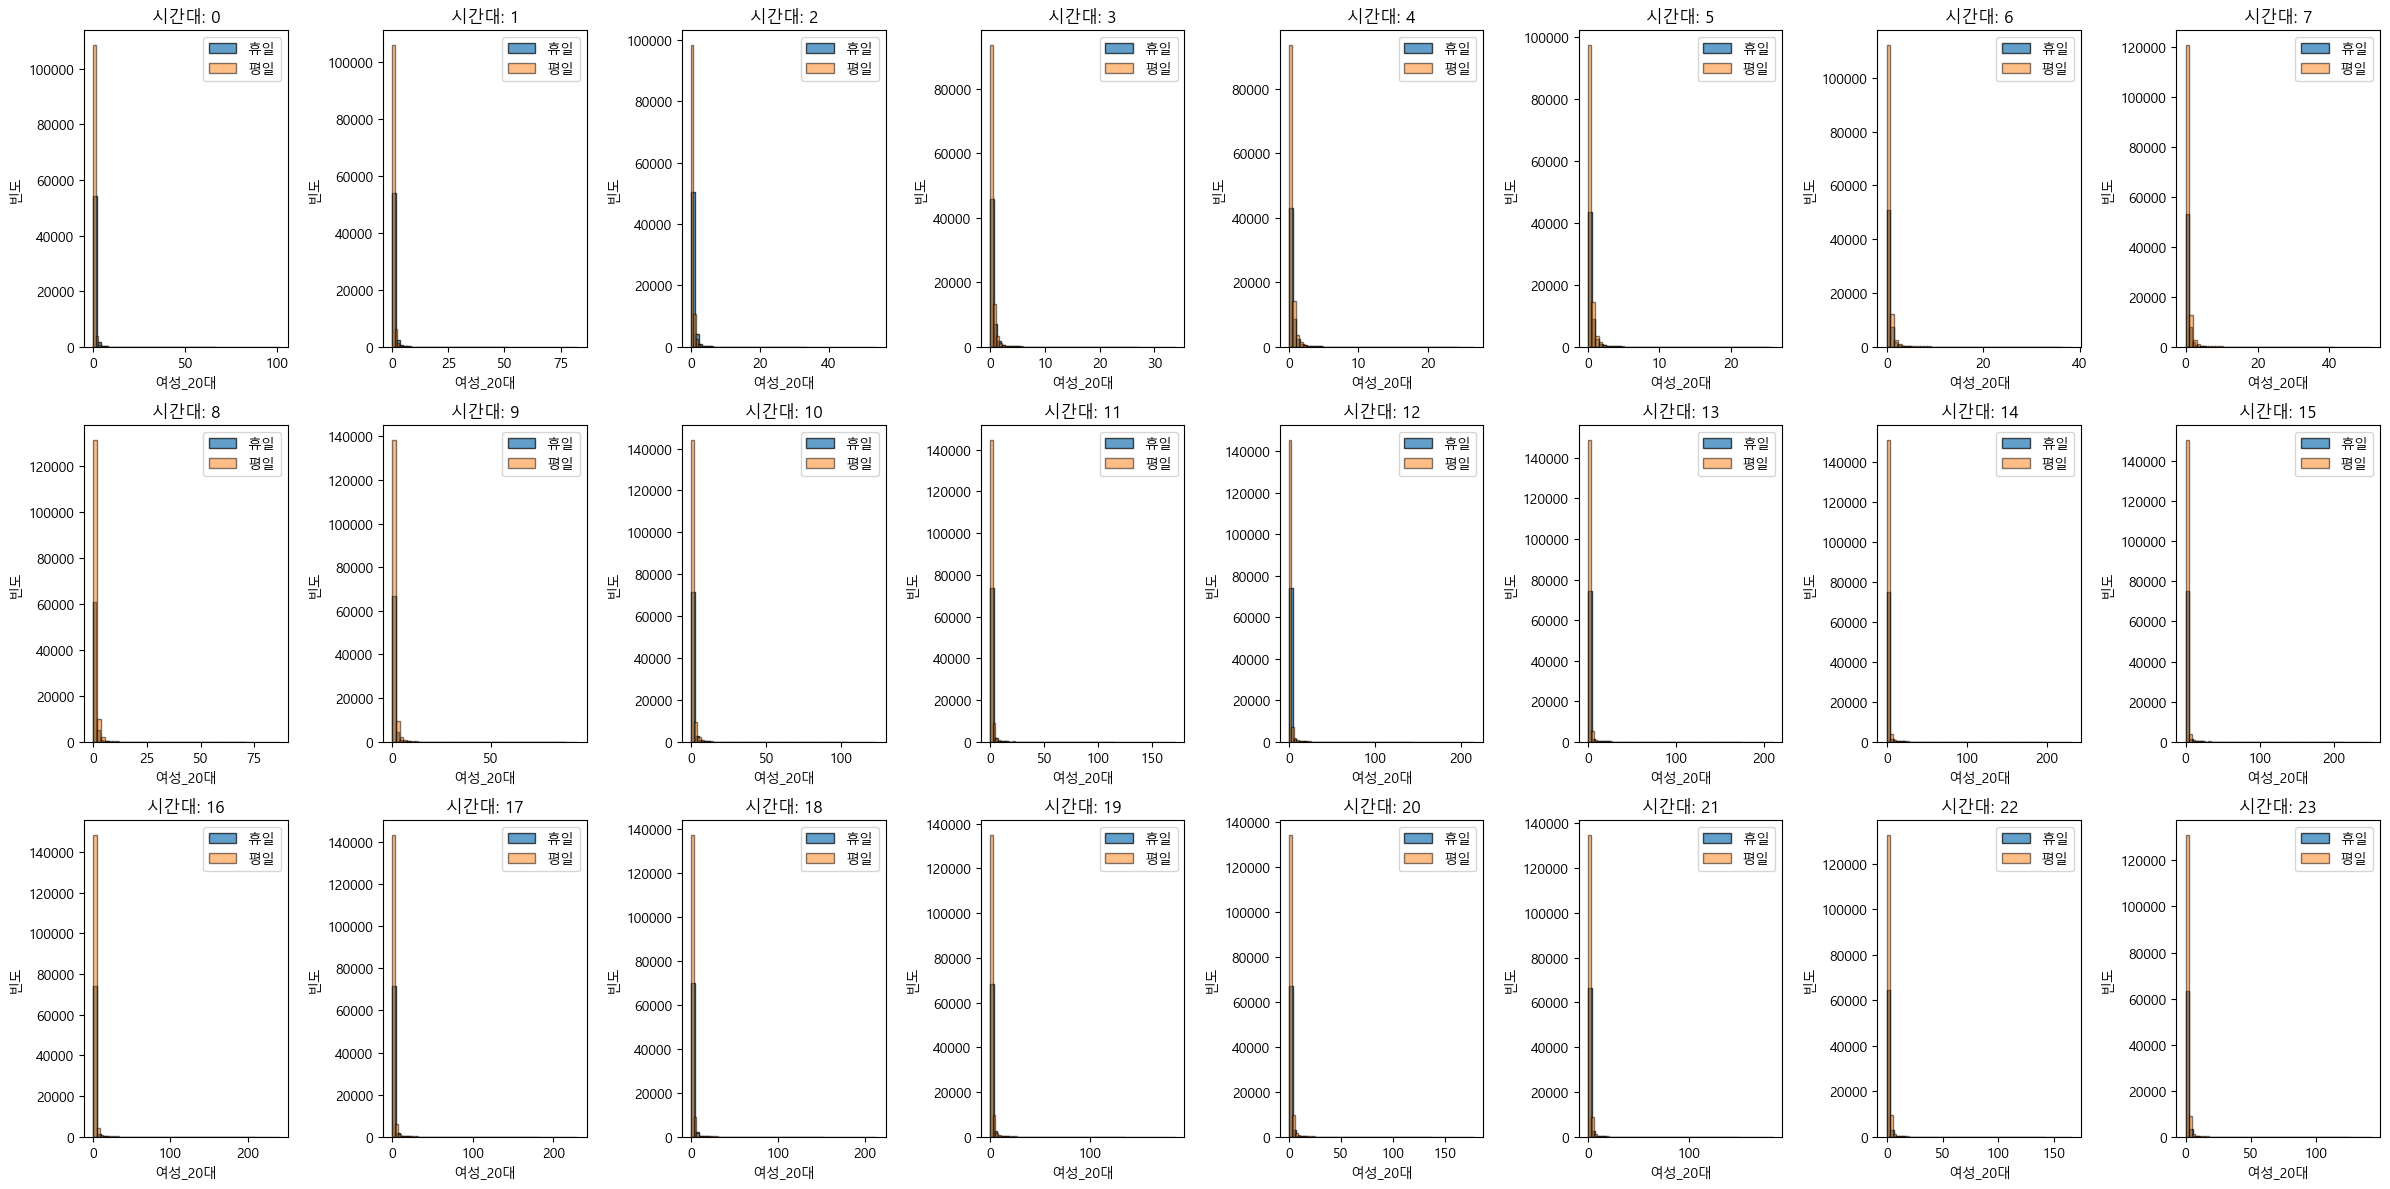

In [26]:
# 시간대 리스트를 0에서 23까지 순서대로 정렬
time_slots = sorted(pop_may_20['시간대'].unique())

# 서브플롯을 3x8 배열로 설정
fig, axes = plt.subplots(3, 8, figsize=(24, 12))
axes = axes.ravel() 

# 시간대별로 히스토그램을 생성
for idx, time_slot in enumerate(time_slots):
    # '휴일'과 '평일'을 각각 시간대에 따라 필터링
    holiday_data_time = pop_may_20[(pop_may_20['holiday'] == '휴일') & (pop_may_20['시간대'] == time_slot)]
    weekday_data_time = pop_may_20[(pop_may_20['holiday'] == '평일') & (pop_may_20['시간대'] == time_slot)]
    
    # 히스토그램 생성
    axes[idx].hist(holiday_data_time['여성_20대'], bins=50, edgecolor='black', alpha=0.7, label='휴일')
    axes[idx].hist(weekday_data_time['여성_20대'], bins=50, edgecolor='black', alpha=0.5, label='평일')

    # 서브플롯 설정
    axes[idx].set_title(f'시간대: {time_slot}')
    axes[idx].set_xlabel('여성_20대')
    axes[idx].set_ylabel('빈도')
    axes[idx].legend()

# 여백 조정 및 출력
plt.tight_layout()
plt.show()

In [27]:
# 중앙값을 이용하여 그룹화 
final_pop_may_20 = pop_may_20.groupby(['셀번호', '시간대', 'holiday']).agg({
    '여성_20대': 'median',  
    'x좌표': 'first',       
    'y좌표': 'first',       
    '행정동코드': 'first'   
}).reset_index()

In [28]:
# final_pop_may_20에 unique_cells 병합
columns_to_merge = ['셀번호', 'latitude', 'longitude']
unique_cells_reduced = unique_cells[columns_to_merge]
final_pop_may_20 = pd.merge(final_pop_may_20, unique_cells_reduced, on='셀번호', how='left')


In [29]:
# final_pop_may_20에 한글로 표기된 행정동명과 병합
final_pop_may_20 = pd.merge(final_pop_may_20, hdong[['행정동코드', "읍면동명"]], how="left", left_on="행정동코드", right_on="행정동코드")
final_pop_may_20 = final_pop_may_20.drop_duplicates(subset=['셀번호', '시간대', 'holiday']).reset_index(drop=True)

In [30]:
# final_pop_may_20 데이터프레임을 csv파일로 저장 
#final_pop_may_20.to_csv('final_pop_may_20.csv', index=False, encoding='utf-8-sig')

## 3. 대전 중구의 5월 20대 여성 유동인구(final_pop_may_20)시각화 

In [31]:
# json파일과 사용하기 용이하게 행정동코드에 '00' 붙이기
final_pop_may_20['행정동확장코드'] = final_pop_may_20['행정동코드'].astype(str) + '00'

# 변경된 행정동코드 확인
final_pop_may_20['행정동확장코드'].head()


0    3014074000
1    3014074000
2    3014074000
3    3014074000
4    3014074000
Name: 행정동확장코드, dtype: object

### 3.1 평일 시각화

In [32]:
# GeoJSON 파일 위치
os.chdir("../data")

# GeoJSON 파일 로드 (대전 중구의 경계선 그리기 위함)
with open('./HangJeongDong_ver20241001.geojson', 'r', encoding='utf-8') as f:
    hd_geo = json.load(f)

# 대전 중구에 해당하는 행정동만 필터링
jung_gu_geo = {
    "type": "FeatureCollection",
    "features": [feature for feature in hd_geo['features'] if '대전광역시 중구' in feature['properties']['adm_nm']]
}

# 평일 데이터만 필터링
weekday_data = final_pop_may_20[final_pop_may_20['holiday'] == '평일']

# 폴더 생성: 히트맵을 저장할 디렉토리
if not os.path.exists('heatmap_frames_평일'):
    os.makedirs('heatmap_frames_평일')

# 각 시간대에 대한 히트맵 생성 및 HTML 저장
image_paths = []
options = webdriver.ChromeOptions()
options.add_argument("--headless")
driver = webdriver.Chrome(options=options)

# 시간대를 0부터 23까지 정렬
for time_period in sorted(weekday_data['시간대'].unique()):
    # 시간대별 데이터 필터링
    filtered_data = weekday_data[weekday_data['시간대'] == time_period]

    # 대전 중구 중심으로 지도 생성 
    m = folium.Map(location=[36.280, 127.4198], zoom_start=12)  

    # 스타일 함수 정의
    def style_function(feature):
        return {
            'fillOpacity': 0,  # 내부 색상 투명도를 0으로 설정
            'weight': 3,       # 경계선 굵기
            'color': 'black'    # 경계선 색상
        }
    
    # 중구의 행정동 경계선을 지도에 추가 (경계선만 표시)
    folium.GeoJson(
        jung_gu_geo,
        style_function=style_function,  
        name="geojson"
    ).add_to(m)

    # 히트맵에 사용될 데이터 (latitude, longitude, 여성_20대)
    heat_data = [[row['latitude'], row['longitude'], row['여성_20대']] for index, row in filtered_data.iterrows()]

    # 히트맵 추가
    folium.plugins.HeatMap(heat_data, radius=15).add_to(m)

    # HTML로 저장
    map_html = f'heatmap_frames_평일/heatmap_평일_{time_period}.html'
    m.save(map_html)

    # HTML을 이미지로 저장
    driver.get(f'file://{os.path.abspath(map_html)}')
    time.sleep(2)  # 지도가 로드될 시간을 확보

    img_path = f'heatmap_frames_평일/heatmap_평일_{time_period}.png'
    driver.save_screenshot(img_path)

    # 스크린샷 이미지를 불러와서 시간대 텍스트 추가
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)
    
    # 폰트 설정 (ttf 파일 경로와 크기를 설정)
    font_path = "C:/Windows/Fonts/arial.ttf"  # Windows 폰트 경로 
    font = ImageFont.truetype(font_path, size=40) 

    # 시간 텍스트 추가 (왼쪽 상단에 추가)
    text = f'{time_period:02}:00'
    draw.text((100, 10), text, font=font, fill="black")

    # 이미지 저장
    img.save(img_path)

    # 이미지 경로를 리스트에 추가
    image_paths.append(img_path)

driver.quit()

# 이미지들을 GIF로 저장
gif_path = 'heatmap_animation_평일.gif'
with imageio.get_writer(gif_path, mode='I', duration=10, loop=0) as writer:
    for img_path in image_paths:
        image = Image.open(img_path)
        writer.append_data(imageio.imread(img_path))

# 결과 GIF 파일 확인
print(f'GIF 저장 완료: {gif_path}')

GIF 저장 완료: heatmap_animation_평일.gif


### 3.2 휴일 시각화

In [33]:
# GeoJSON 파일 위치
os.chdir("../data")

# GeoJSON 파일 로드 (대전 중구의 경계선 그리기 위함)
with open('./HangJeongDong_ver20241001.geojson', 'r', encoding='utf-8') as f:
    hd_geo = json.load(f)

# 대전 중구에 해당하는 행정동만 필터링
jung_gu_geo = {
    "type": "FeatureCollection",
    "features": [feature for feature in hd_geo['features'] if '대전광역시 중구' in feature['properties']['adm_nm']]
}

# 휴일 데이터만 필터링
weekend_data = final_pop_may_20[final_pop_may_20['holiday'] == '휴일']

# 폴더 생성: 히트맵을 저장할 디렉토리
if not os.path.exists('heatmap_frames_휴일'):
    os.makedirs('heatmap_frames_휴일')

# 각 시간대에 대한 히트맵 생성 및 HTML 저장
image_paths = []
options = webdriver.ChromeOptions()
options.add_argument("--headless")
driver = webdriver.Chrome(options=options)

# 시간대를 0부터 23까지 정렬
for time_period in sorted(weekend_data['시간대'].unique()):
    # 시간대별 데이터 필터링
    filtered_data = weekend_data[weekend_data['시간대'] == time_period]

    # 지도 생성 
    m = folium.Map(location=[36.280, 127.4198], zoom_start=12) 

    # 스타일 함수 정의
    def style_function(feature):
        return {
            'fillOpacity': 0,  # 내부 색상 투명도를 0으로 설정
            'weight': 3,       # 경계선 굵기
            'color': 'black'    # 경계선 색상
        }
    
    # 중구의 행정동 경계선을 지도에 추가 (경계선만 표시)
    folium.GeoJson(
        jung_gu_geo,
        style_function=style_function,  
        name="geojson"
    ).add_to(m)

    # 히트맵 데이터 준비 (latitude, longitude, 여성_20대)
    heat_data = [[row['latitude'], row['longitude'], row['여성_20대']] for index, row in filtered_data.iterrows()]

    # 히트맵 추가
    folium.plugins.HeatMap(heat_data, radius=15).add_to(m)

    # HTML로 저장
    map_html = f'heatmap_frames_휴일/heatmap_휴일_{time_period}.html'
    m.save(map_html)

    # HTML을 이미지로 저장
    driver.get(f'file://{os.path.abspath(map_html)}')
    time.sleep(2)  # 지도가 로드될 시간을 확보

    img_path = f'heatmap_frames_휴일/heatmap_휴일_{time_period}.png'
    driver.save_screenshot(img_path)

    # 스크린샷 이미지를 불러와서 시간대 텍스트 추가
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)
    
    # 폰트 설정 (ttf 파일 경로와 크기를 설정)
    font_path = "C:/Windows/Fonts/arial.ttf"  # Windows 폰트 경로 
    font = ImageFont.truetype(font_path, size=40)  

    # 시간 텍스트 추가 (왼쪽 상단에 추가)
    text = f'{time_period:02}:00'
    draw.text((100, 10), text, font=font, fill="black") 

    # 이미지 저장
    img.save(img_path)

    # 이미지 경로를 리스트에 추가
    image_paths.append(img_path)

driver.quit()

# 이미지들을 GIF로 저장 
gif_path = 'heatmap_animation_휴일.gif'
with imageio.get_writer(gif_path, mode='I', duration=10, loop=0) as writer:
    for img_path in image_paths:
        image = Image.open(img_path)
        writer.append_data(imageio.imread(img_path))

# 결과 GIF 파일 확인
print(f'GIF 저장 완료: {gif_path}')

GIF 저장 완료: heatmap_animation_휴일.gif


### 3.3 시간대별 상위 5개 셀 시각화

In [34]:
# 평일 시간대별 상위 5개의 cell 데이터
top_5_평일 = (
    final_pop_may_20[final_pop_may_20['holiday'] == '평일']
    .groupby('시간대')
    .apply(lambda x: x.nlargest(5, '여성_20대'))  # 각 시간대별 상위 5개의 행정동 선택
    .reset_index(drop=True)
)

In [35]:
# 휴일 시간대별 상위 5개의 cell 데이터
top_5_휴일 = (
    final_pop_may_20[final_pop_may_20['holiday'] == '휴일']
    .groupby('시간대')
    .apply(lambda x: x.nlargest(5, '여성_20대'))  # 각 시간대별 상위 5개의 행정정동 선택
    .reset_index(drop=True)
)

In [36]:
# 평일 상위 5개 cell 시각화

# GeoJSON 파일 위치
os.chdir("../data")

# GeoJSON 파일 로드 (대전 중구의 경계선 그리기 위함)
with open('./HangJeongDong_ver20241001.geojson', 'r', encoding='utf-8') as f:
    hd_geo = json.load(f)

# 대전 중구에 해당하는 행정동만 필터링
jung_gu_geo = {
    "type": "FeatureCollection",
    "features": [feature for feature in hd_geo['features'] if '대전광역시 중구' in feature['properties']['adm_nm']]
}

# 폴더 생성: 히트맵을 저장할 디렉토리
if not os.path.exists('heatmap_top5_평일'):
    os.makedirs('heatmap_top5_평일')

# 각 시간대에 대한 히트맵 생성 및 HTML 저장
image_paths = []
options = webdriver.ChromeOptions()
options.add_argument("--headless")
driver = webdriver.Chrome(options=options)

# 시간대를 0부터 23까지 정렬
for time_period in sorted(top_5_평일['시간대'].unique()):
    # 시간대별 데이터 필터링
    filtered_data = top_5_평일[top_5_평일['시간대'] == time_period]

    # 지도 생성
    m = folium.Map(location=[36.280, 127.4198], zoom_start=12)

    # 스타일 함수 정의
    def style_function(feature):
        return {
            'fillOpacity': 0,  # 내부 색상 투명도를 0으로 설정
            'weight': 3,       # 경계선 굵기
            'color': 'black'    # 경계선 색상
        }

    # 중구의 행정동 경계선을 지도에 추가 (경계선만 표시)
    folium.GeoJson(
        jung_gu_geo,
        style_function=style_function,  # 스타일 적용
        name="geojson"
    ).add_to(m)

    # 히트맵 데이터 준비 (latitude, longitude, 여성_20대)
    heat_data = [[row['latitude'], row['longitude'], row['여성_20대']] for index, row in filtered_data.iterrows()]

    # 히트맵 추가
    HeatMap(heat_data, radius=15).add_to(m)

    # HTML로 저장
    map_html = f'heatmap_top5_평일/heatmap_top5_평일_{time_period}.html'
    m.save(map_html)

    # HTML을 이미지로 저장
    driver.get(f'file://{os.path.abspath(map_html)}')
    time.sleep(2)  # 지도가 로드될 시간을 확보

    img_path = f'heatmap_top5_평일/heatmap_top5_평일_{time_period}.png'
    driver.save_screenshot(img_path)

    # 스크린샷 이미지를 불러와서 시간대 텍스트 추가
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)

    # 폰트 설정 (ttf 파일 경로와 크기를 설정)
    font_path = "C:/Windows/Fonts/arial.ttf"  # Windows 폰트 경로
    font = ImageFont.truetype(font_path, size=40)  

    # 시간 텍스트 추가 (왼쪽 상단에 추가)
    text = f'{time_period:02}:00'
    draw.text((100, 10), text, font=font, fill="black") 

    # 이미지 저장
    img.save(img_path)

    # 이미지 경로를 리스트에 추가
    image_paths.append(img_path)

driver.quit()

# 이미지들을 GIF로 저장 
gif_path = 'heatmap_top5_평일.gif'
with imageio.get_writer(gif_path, mode='I', duration=10, loop=0) as writer:
    for img_path in image_paths:
        image = Image.open(img_path)
        writer.append_data(imageio.imread(img_path))

# 결과 GIF 파일 확인
print(f'GIF 저장 완료: {gif_path}')


GIF 저장 완료: heatmap_top5_평일.gif


In [37]:
# 휴일 상위 5개 cell 시각화

# GeoJSON 파일 위치
os.chdir("../data")

# GeoJSON 파일 로드 (대전 중구의 경계선 그리기 위함)
with open('./HangJeongDong_ver20241001.geojson', 'r', encoding='utf-8') as f:
    hd_geo = json.load(f)

# 대전 중구에 해당하는 행정동만 필터링
jung_gu_geo = {
    "type": "FeatureCollection",
    "features": [feature for feature in hd_geo['features'] if '대전광역시 중구' in feature['properties']['adm_nm']]
}

# 폴더 생성: 히트맵을 저장할 디렉토리
if not os.path.exists('heatmap_top5_휴일'):
    os.makedirs('heatmap_top5_휴일')

# 각 시간대에 대한 히트맵 생성 및 HTML 저장
image_paths = []
options = webdriver.ChromeOptions()
options.add_argument("--headless")
driver = webdriver.Chrome(options=options)

# 시간대를 0부터 23까지 정렬
for time_period in sorted(top_5_휴일['시간대'].unique()):
    # 시간대별 데이터 필터링
    filtered_data = top_5_휴일[top_5_휴일['시간대'] == time_period]

    # 지도 생성 
    m = folium.Map(location=[36.280, 127.4198], zoom_start=12)

    # 스타일 함수 정의
    def style_function(feature):
        return {
            'fillOpacity': 0,  # 내부 색상 투명도를 0으로 설정
            'weight': 3,       # 경계선 굵기
            'color': 'black'    # 경계선 색상
        }

    # 중구의 행정동 경계선을 지도에 추가 (경계선만 표시)
    folium.GeoJson(
        jung_gu_geo,
        style_function=style_function,  
        name="geojson"
    ).add_to(m)

    # 히트맵 데이터 준비 (latitude, longitude, 여성_20대)
    heat_data = [[row['latitude'], row['longitude'], row['여성_20대']] for index, row in filtered_data.iterrows()]

    # 히트맵 추가
    HeatMap(heat_data, radius=15).add_to(m)

    # HTML로 저장
    map_html = f'heatmap_top5_휴일/heatmap_top5_휴일_{time_period}.html'
    m.save(map_html)

    # HTML을 이미지로 저장
    driver.get(f'file://{os.path.abspath(map_html)}')
    time.sleep(2)  # 지도가 로드될 시간을 확보

    img_path = f'heatmap_top5_휴일/heatmap_top5_휴일_{time_period}.png'
    driver.save_screenshot(img_path)

    # 스크린샷 이미지를 불러와서 시간대 텍스트 추가
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)

    # 폰트 설정 (ttf 파일 경로와 크기를 설정)
    font_path = "C:/Windows/Fonts/arial.ttf"  # Windows 폰트 경로 
    font = ImageFont.truetype(font_path, size=40)  

    # 시간 텍스트 추가 (왼쪽 상단에 추가)
    text = f'{time_period:02}:00'
    draw.text((100, 10), text, font=font, fill="black")  

    # 이미지 저장
    img.save(img_path)

    # 이미지 경로를 리스트에 추가
    image_paths.append(img_path)

driver.quit()

# 이미지들을 GIF로 저장
gif_path = 'heatmap_top5_휴일.gif'
with imageio.get_writer(gif_path, mode='I', duration=10, loop=0) as writer:
    for img_path in image_paths:
        image = Image.open(img_path)
        writer.append_data(imageio.imread(img_path))

# 결과 GIF 파일 확인
print(f'GIF 저장 완료: {gif_path}')


GIF 저장 완료: heatmap_top5_휴일.gif
